In [1]:
import pandas as pd

data = pd.read_csv("final_data_to_train.csv")
filtered_data_id6 = data[data['sourceId'] == 6]

filtered_data_id6.head()

,meterId,sourceId,totalVehicles,provinceId,municipalityId,latitude,longitude,year,month,day,hour,minute
5600764,7131,6,58,1,59,42.854425,-2.673455,2022,4,2,0,30
5600765,7130,6,52,1,59,42.852978,-2.673627,2022,4,2,0,30
5600766,5791,6,52,1,59,42.845867,-2.667962,2022,4,2,0,30
5600767,5790,6,59,1,59,42.846433,-2.667790,2022,4,2,0,30
5600768,7126,6,3,1,59,42.849391,-2.687960,2022,4,2,0,30


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb

X = filtered_data_id6.drop(columns=['totalVehicles','sourceId', 'provinceId', 'year'])
y = filtered_data_id6['totalVehicles']

numerical_vars = ['meterId','municipalityId','latitude','longitude','month','day', 'hour', 'minute']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers = [('num', StandardScaler(), numerical_vars)]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(learning_rate=0.1, max_depth=15, n_estimators=300))
])
print('Done')

Done


In [3]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.5],     # Example learning rate values
    'regressor__max_depth': [5, 10, 15],              # Example max depth values
    'regressor__n_estimators': [100, 220, 300]        # Example number of estimators values
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring='r2', verbose=3)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100;, score=0.191 total time= 3.3min
[CV 2/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=100;, score=0.191 total time= 3.3min
[CV 1/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=220;, score=0.352 total time= 7.4min
[CV 2/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=220;, score=0.349 total time= 7.3min
[CV 1/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=300;, score=0.407 total time= 9.8min
[CV 2/2] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=300;, score=0.406 total time= 9.9min
[CV 1/2] END regressor__learning_rate=0.01, regressor__max_depth=10, regressor__n_estimators=100;, score=0.432 total time= 7.1min
[CV 2/2] END regressor__learning_ra

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get the best model
pipeline.fit(X_train,y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate evaluation scores
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation scores
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 211.60030111233493
Mean Absolute Error (MAE): 7.053164586511197
R-squared Score (R2): 0.9351422947322535


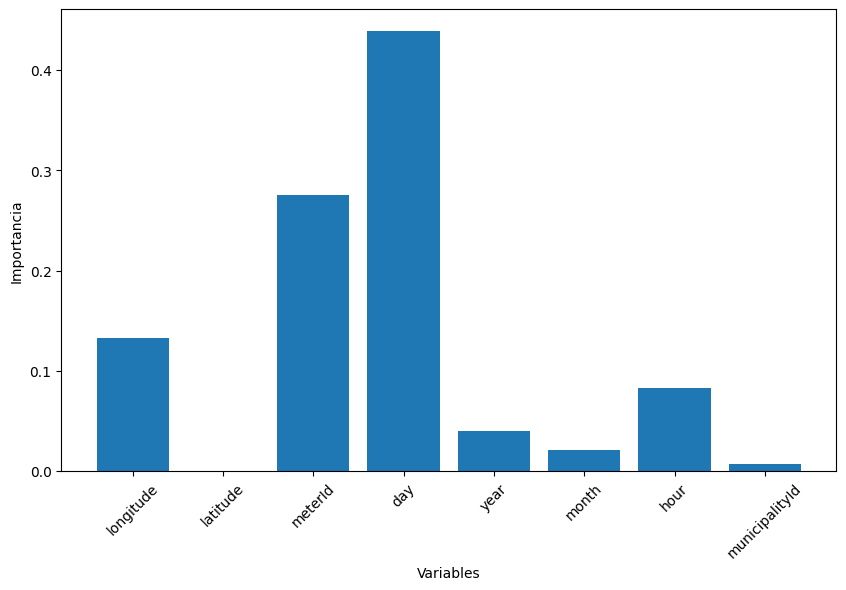

In [6]:
import matplotlib.pyplot as plt
best_pipeline = grid_search.best_estimator_
xgb_model = best_pipeline.named_steps['regressor']

# Get feature importance scores of the XGBoost model
importance_scores = xgb_model.feature_importances_

# Sort features based on their importance scores
sorted_indices = importance_scores.argsort()[::-1]

# Select the top-k features
k = 8  # Adjust the value of k as needed

feature_names = ['meterId', 'municipalityId', 'latitude', 'longitude', 'year', 'month',
       'day', 'hour', 'minute']

# Get the feature names corresponding to the selected features
selected_feature_names = [feature_names[i] for i in sorted_indices[:k]]

# Get the importance scores of the selected features
selected_importances = importance_scores[:k]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(k), selected_importances, tick_label=selected_feature_names)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()

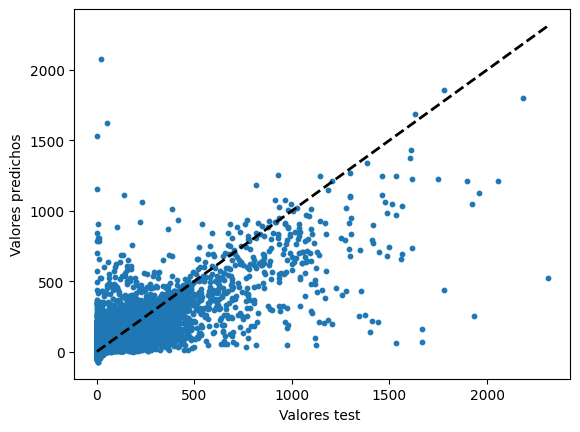

In [9]:
# Plotting predicted values vs. test values
plt.scatter(y_test, y_pred, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plotting the diagonal line
plt.xlabel('Valores test ')
plt.ylabel('Valores predichos')
plt.show()

In [12]:

predicted_data = X_test[['meterId','latitude', 'longitude', 'month']].copy()
predicted_data['PredictedValues'] = y_pred  # Assuming y_pred contains the predicted values


In [32]:
predicted_data.head()

,meterId,latitude,longitude,month,PredictedValues
10793263,6773,42.839385,-2.696458,3,54.081573
11280202,9953,42.857178,-2.668986,2,-0.832366
12092614,8498,42.861723,-2.673455,11,52.157112
12975342,6799,42.858154,-2.673562,9,138.123505
11822453,5943,42.841399,-2.686587,11,112.208702


In [13]:
predicted_data.reset_index(drop=True, inplace=True)

In [38]:
print(predicted_data['meterId'].value_counts())

meterId
 6452     7140
 7469     7099
 6831     7095
 4298     7081
 8466     7078
          ... 
 4282     5604
-1        1026
 11522     383
 11516     377
 4877      365
Name: count, Length: 308, dtype: int64


In [39]:
# Assuming your DataFrame has 'month', 'meterId', and 'value' columns
sum_values = predicted_data.groupby(['month', 'meterId'])['PredictedValues'].sum()
print(sum_values)


month  meterId
1      645        33086.945312
       736        13205.892578
       1064       38714.679688
       1065       25045.214844
       1067       24726.572266
                      ...     
12     11556      51840.921875
       11584      30815.148438
       11676      55819.066406
       11937       4085.569092
       11948      12086.669922
Name: PredictedValues, Length: 3651, dtype: float32


In [14]:
# Assuming your DataFrame has 'meterId', 'lat', 'lon', 'month', and 'value' columns
new_df = predicted_data.groupby('meterId').agg({'latitude': 'first', 'longitude': 'first', 'month': 'first', 'PredictedValues': 'sum'}).reset_index()
new_df.head()


,meterId,latitude,longitude,month,PredictedValues
0,-1,NaN,NaN,12,44615.292969
1,645,42.839218,-2.696132,3,400082.125000
2,736,42.859863,-2.672838,2,161694.406250
3,1064,42.861267,-2.672445,3,466190.437500
4,1065,42.837341,-2.698278,11,343335.093750


In [41]:
print(new_df)

     meterId   latitude  longitude  month  PredictedValues
0         -1        NaN        NaN     12     44615.292969
1        645  42.839218  -2.696132      3    400082.125000
2        736  42.859863  -2.672838      2    161694.406250
3       1064  42.861267  -2.672445      3    466190.437500
4       1065  42.837341  -2.698278     11    343335.093750
..       ...        ...        ...    ...              ...
303    11556  42.852158  -2.694100      1    572260.750000
304    11584  42.856812  -2.675727     10    318588.281250
305    11676  42.854309  -2.673229     10    559151.125000
306    11937  42.858505  -2.686018      1     25197.410156
307    11948  42.851395  -2.684467     12     92258.515625

[308 rows x 5 columns]


In [15]:
new_df.dropna(inplace=True)

In [16]:
# Filter predicted_data for month 6
predicted_data_month6 = predicted_data[predicted_data['month'] == 6]

In [52]:
print(predicted_data_month6['PredictedValues'].max())

515.21027


In [17]:
predicted_data_month6['PredictedValues'] = predicted_data_month6['PredictedValues'].clip(lower=1)

/var/folders/gh/yt97y6vj0_79f2lwfvsdnjpw0000gn/T/ipykernel_34252/4140530298.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
print(predicted_data_month6['PredictedValues'].min())

1.0


In [23]:
import plotly.graph_objects as go
from plotly.offline import plot

scaling_factor = 0.05

fig = go.Figure(go.Densitymapbox(
    lat=predicted_data_month6['latitude'],
    lon=predicted_data_month6['longitude'],
    z=predicted_data_month6['PredictedValues']*scaling_factor,
    radius=predicted_data_month6['PredictedValues']*scaling_factor+1,  # Increase the radius value to make the dots bigger
    colorscale = 'YlOrRd',
    opacity=0.75,
    showscale=False
))

fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox_center={"lat": 42.8496, "lon": -2.6729},  # Set the center coordinates to Vitoria/Gasteiz
    mapbox_zoom=13  # Adjust the zoom level as desired
)

# Generate an HTML file with the plot
plot(fig, filename='density_map_id6_month6.html')


In [73]:
new_df.to_csv('predictions/predicted_data_id6_2022.csv', index=False)